In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import scipy

# Data

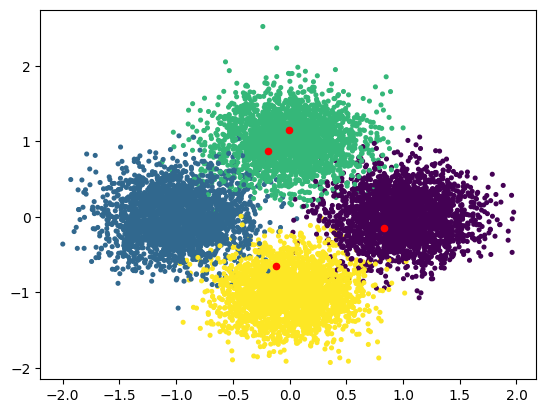

In [20]:
p = [1/4, 1/4, 1/4, 1/4]
mu = [[1, 0], [-1, 0], [0, 1], [0, -1]]
sigma = [[0.1, 0], [0, 0.1]]

samples = []
sample_class = []
for i in range(10000):
    z = np.argmax(np.random.multinomial(1, p))
    curr_sample = np.random.multivariate_normal(mu[z], sigma)
    samples.append(curr_sample)
    sample_class.append(z)

samples = np.array(samples)
initial_mean = samples[np.random.randint(0, len(samples), 4), :]

plt.figure()
plt.scatter(samples[:, 0], samples[:, 1], 7, sample_class)
plt.scatter(initial_mean[:, 0], initial_mean[:, 1], 20, 'r')

# Model

In [137]:
class Encoder(nn.Module):
    def __init__(self, in_dim, data_dim):
        super().__init__()
        self.ln1 = nn.Linear(in_dim, 8)
        self.ln2 = nn.Linear(8, 16)
        self.ln3 = nn.Linear(16, 16)
        self.ln4 = nn.Linear(16, data_dim)
        self.relu = nn.ReLU()
    
    def forward(self, z):
        x = self.relu(self.ln1(z))
        x = self.relu(self.ln2(x))
        x = self.relu(self.ln3(x))
        x = self.ln4(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.ln1 = nn.Linear(in_dim, 8)
        self.ln2 = nn.Linear(8, 16)
        self.ln3 = nn.Linear(16, 32)
        self.ln4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        # self.loss = nn.BCEWithLogitsLoss()
        self.loss = nn.Softplus()
    
    def forward(self, x):
        x = self.relu(self.ln1(x))
        x = self.relu(self.ln2(x))
        x = self.relu(self.ln3(x))
        x = self.ln4(x)
        return x


In [22]:
class MixData(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data
    
    def __len__(self):
        return data.shape[0]
    
    def __getitem__(self, index):
        return data[index]

In [138]:
batch_size = 1000
data = torch.tensor(samples, dtype=torch.float)
train_data = MixData(data)
train_dataloader = DataLoader(train_data, batch_size, shuffle=True)
data_dim = train_data[0].shape[0]
noise_dim = 8

enc = Encoder(noise_dim, data_dim) 
disc = Discriminator(data_dim)
enc_optim = torch.optim.Adam(enc.parameters(), lr=0.0001, betas=(0.5, 0.999))
disc_optim = torch.optim.Adam(disc.parameters(), lr=0.001, betas=(0.5, 0.999))


for epoch in range(10000):
    
    disc_optim.zero_grad()
    z = torch.tensor(np.random.rand(batch_size, noise_dim), dtype=torch.float)
    with torch.no_grad():
        x_fake = enc(z)
    x_fake_p = disc(x_fake)
    x_true = next(iter(train_dataloader))
    x_true_p = disc(x_true)
    # fake_as_false = torch.zeros_like(x_fake_p)
    # true_as_true = torch.ones_like(x_true_p)
    # disc_loss = disc.loss(x_fake_p, fake_as_false) + disc.loss(x_true_p, true_as_true)
    disc_loss = disc.loss(x_fake_p).mean() + disc.loss(-x_true_p).mean()
    disc_loss.backward(retain_graph=True)
    disc_optim.step()
    
    enc_optim.zero_grad()
    z = torch.tensor(np.random.rand(batch_size, noise_dim), dtype=torch.float)
    x_fake = enc(z)
    x_fake_p = disc(x_fake)
    # fake_as_true = torch.ones_like(x_fake_p)
    # gen_loss = disc.loss(x_fake_p, fake_as_true)
    gen_loss = disc.loss(-x_fake_p).mean()
    gen_loss.backward()
    enc_optim.step()

    if epoch%5 == 0:
        print(f'epoch : {epoch}, gen_loss : {gen_loss}, disc_loss : {disc_loss}')

epoch : 0, gen_loss : 0.7635664939880371, disc_loss : 1.3920128345489502
epoch : 5, gen_loss : 0.7535580992698669, disc_loss : 1.3871866464614868
epoch : 10, gen_loss : 0.7448595762252808, disc_loss : 1.3825666904449463
epoch : 15, gen_loss : 0.7371907234191895, disc_loss : 1.3781211376190186
epoch : 20, gen_loss : 0.7306203842163086, disc_loss : 1.3723887205123901
epoch : 25, gen_loss : 0.7249652147293091, disc_loss : 1.3655728101730347
epoch : 30, gen_loss : 0.7215665578842163, disc_loss : 1.3575117588043213
epoch : 35, gen_loss : 0.7182681560516357, disc_loss : 1.3451988697052002
epoch : 40, gen_loss : 0.7185637354850769, disc_loss : 1.3333828449249268
epoch : 45, gen_loss : 0.7219000458717346, disc_loss : 1.315624713897705
epoch : 50, gen_loss : 0.7280458807945251, disc_loss : 1.2971138954162598
epoch : 55, gen_loss : 0.7371740937232971, disc_loss : 1.265528917312622
epoch : 60, gen_loss : 0.7531200647354126, disc_loss : 1.2266573905944824
epoch : 65, gen_loss : 0.7752344012260437,

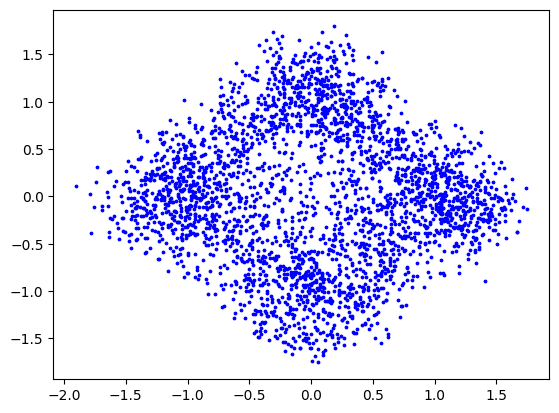

In [139]:
noise = np.random.rand(3000, noise_dim)
z = torch.tensor(noise, dtype=torch.float)
gen_x = enc(z).detach().numpy()

# plt.figure()
# plt.scatter(noise[:, 0], noise[:, 1], 3, 'b')

plt.figure()
plt.scatter(gen_x[:, 0], gen_x[:, 1], 3, 'b')

In [41]:
enc.parameters

<bound method Module.parameters of Encoder(
  (ln1): Linear(in_features=2, out_features=16, bias=True)
  (ln2): Linear(in_features=16, out_features=16, bias=True)
  (ln3): Linear(in_features=16, out_features=2, bias=True)
  (relu): ReLU()
)>

# training GAN with GRL

In [140]:
class GRL(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return x
    
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        return -grad_output


class GANModel(nn.Module):
    def __init__(self, noise_dim, data_dim):
        super().__init__()
        self.encoder = Encoder(noise_dim, data_dim)
        self.grl = GRL.apply
        self.discriminator = Discriminator(data_dim)
        # self.loss = nn.BCEWithLogitsLoss()
        self.loss = nn.Softplus()
    
    def forward(self, z, true_data):
        gen_data = self.grl(self.encoder(z))
        # gen_data = GRL.apply(self.encoder(z))
        gen_data_p = self.discriminator(gen_data)
        true_data_p = self.discriminator(true_data)

        return gen_data, gen_data_p, true_data_p

In [141]:
batch_size = 1000
epochs = 10000
data = torch.tensor(samples, dtype=torch.float)
train_data = MixData(data)
train_dataloader = DataLoader(train_data, batch_size, shuffle=True)
data_dim = train_data[0].shape[0]
noise_dim = 8

gan_model = GANModel(noise_dim, data_dim)
optim = torch.optim.Adam(gan_model.parameters(), lr=0.001, betas=(0.5, 0.99))
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=int(epochs/4), eta_min= 0.0001)
# lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.999)
all_lr = []

for epoch in range(epochs):
    noise = torch.tensor(np.random.rand(batch_size, noise_dim), dtype=torch.float)
    true_data = next(iter(train_dataloader))

    optim.zero_grad()
    gen_data, gen_data_p, true_data_p = gan_model(noise, true_data)
    # loss = gan_model.loss(gen_data_p, torch.zeros_like(gen_data_p)) + gan_model.loss(true_data_p, torch.ones_like(true_data_p))
    loss = gan_model.loss(gen_data_p).mean() + gan_model.loss(-true_data_p).mean()
    loss.backward()
    optim.step()
    # lr_scheduler.step()
    # all_lr.append(lr_scheduler.get_last_lr())
    
    if epoch%5 == 0:
        print(f'epoch : {epoch}, loss : {loss}')


epoch : 0, loss : 1.3887131214141846
epoch : 5, loss : 1.3831911087036133
epoch : 10, loss : 1.3778538703918457
epoch : 15, loss : 1.3713053464889526
epoch : 20, loss : 1.3638657331466675
epoch : 25, loss : 1.353727102279663
epoch : 30, loss : 1.342557430267334
epoch : 35, loss : 1.3275474309921265
epoch : 40, loss : 1.3070247173309326
epoch : 45, loss : 1.2863160371780396
epoch : 50, loss : 1.2610177993774414
epoch : 55, loss : 1.2297801971435547
epoch : 60, loss : 1.1969884634017944
epoch : 65, loss : 1.1620967388153076
epoch : 70, loss : 1.1353349685668945
epoch : 75, loss : 1.1264457702636719
epoch : 80, loss : 1.0973118543624878
epoch : 85, loss : 1.076021432876587
epoch : 90, loss : 1.0646820068359375
epoch : 95, loss : 1.0309641361236572
epoch : 100, loss : 0.9834644794464111
epoch : 105, loss : 0.9115972518920898
epoch : 110, loss : 0.8476159572601318
epoch : 115, loss : 0.7764142155647278
epoch : 120, loss : 0.766412615776062
epoch : 125, loss : 0.6977322101593018
epoch : 130,

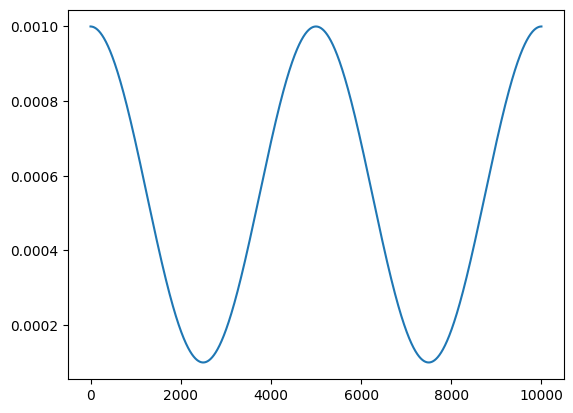

In [135]:
all_lr = np.array(all_lr)
plt.figure()
plt.plot(all_lr[:, 0])

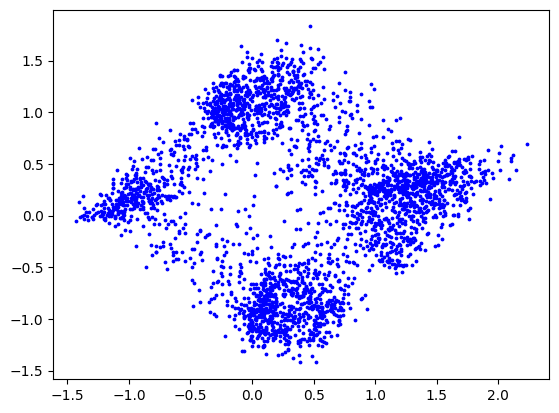

In [142]:
noise = np.random.rand(3000, noise_dim)
z = torch.tensor(noise, dtype=torch.float)
gen_x, gen_data_p, true_data_p = gan_model(z, true_data)
gen_x = gen_x.detach().numpy()

# plt.figure()
# plt.scatter(noise[:, 0], noise[:, 1], 3, 'b')

plt.figure()
plt.scatter(gen_x[:, 0], gen_x[:, 1], 3, 'b')

In [122]:
gan_model.parameters

<bound method Module.parameters of GANModel(
  (encoder): Encoder(
    (ln1): Linear(in_features=8, out_features=8, bias=True)
    (ln2): Linear(in_features=8, out_features=16, bias=True)
    (ln3): Linear(in_features=16, out_features=16, bias=True)
    (ln4): Linear(in_features=16, out_features=2, bias=True)
    (relu): ReLU()
  )
  (discriminator): Discriminator(
    (ln1): Linear(in_features=2, out_features=8, bias=True)
    (ln2): Linear(in_features=8, out_features=16, bias=True)
    (ln3): Linear(in_features=16, out_features=32, bias=True)
    (ln4): Linear(in_features=32, out_features=1, bias=True)
    (relu): ReLU()
    (bce_loss): BCEWithLogitsLoss()
  )
  (loss): BCEWithLogitsLoss()
)>

In [166]:
class CustomGrad(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return nn.Softplus()(x)
    
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        return -grad_output*2


a = torch.tensor(np.array([2, 3]), dtype=torch.float, requires_grad=True)
b = torch.tensor(np.array([1, 5]), dtype=torch.float, requires_grad=True)

f = CustomGrad.apply

pred = f(a**2 + 2*b)
loss = torch.sum(pred)

In [169]:
pred

tensor([ 6.0025, 19.0000], grad_fn=<CustomGradBackward>)

In [170]:
print(a.grad)
print(b.grad)
loss.backward()
print(a.grad)
print(b.grad)


None
None
tensor([ -8., -12.])
tensor([-4., -4.])


# Conditional GAN